In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['aclimdb']


# 1. Carregamento dos dados

In [2]:
# path = 'Review-Imdb/'
path = '../input/aclimdb/aclImdb/'
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testPosFiles = [x for x in os.listdir(path+"test/pos/") if x.endswith(".txt")]
testNegFiles = [x for x in os.listdir(path+"test/neg/") if x.endswith(".txt")]

In [3]:
display(len(positiveFiles))
display(len(negativeFiles))
display(len(testPosFiles))
display(len(testNegFiles))

12500

12500

12500

12500

In [4]:
#Abrindo cada arquivo .txt e adicionando o conteudo ao vetor correspondente

positiveReviews, negativeReviews, testPosReviews, testNegReviews = [], [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for tfile in testPosFiles:
    with open(path+"test/pos/"+tfile, encoding="latin1") as f:
        testPosReviews.append(f.read())
for tfile in testNegFiles:
    with open(path+"test/neg/"+tfile, encoding="latin1") as f:
        testNegReviews.append(f.read())

In [5]:
# Juntando todas as reviews em apenas um dataset

reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    pd.DataFrame({"review":testPosReviews, "label":-1, "file":testPosFiles}),
    pd.DataFrame({"review":testNegReviews, "label":-1, "file":testNegFiles})
], ignore_index=True).sample(frac=1, random_state=1).reset_index(drop=True)
reviews.head()

,review,label,file
0,This is unfortunately Carlin's last recorded H...,-1,4374_9.txt
1,"The vampire ""craze"" has, in my opinion, actual...",-1,155_8.txt
2,The story of an obsessed lover (Shahrukh Khan)...,-1,12055_8.txt
3,I saw most of the episodes of RMFTM as a teena...,0,9397_3.txt
4,"Yes, Giorgio, is a feel good movie. A little r...",1,9750_10.txt


In [6]:
reviews.shape

(50000, 3)

# 2. Exploração dos dados

* Adicionando ao dataset de treino as reviews que possuem as labels 0 (negativo) e 1 (positivo).
* Adicionando ao dataset de teste as reviews que possuem aa labels -1 (teste, tanto negativa quanto positiva).

In [7]:
train = reviews[reviews.label!=-1].sample(frac=0.7, random_state=42) #.reset_index(drop=True)
valid = reviews[reviews.label!=-1].drop(train.index)
test = reviews[reviews.label==-1].reset_index(drop=True)

In [8]:
print(train.shape)
print(valid.shape)
print(test.shape)

(17500, 3)
(7500, 3)
(25000, 3)


In [9]:
print("Treino.")
display(train.head())
print("Valid.")
display(valid.head())
print("Teste.")
display(test.head())

Treino.


,review,label,file
13533,Interesting film about an actual event that to...,0,6575_4.txt
47978,I don't know why I'm taking the time to review...,0,3830_1.txt
19168,I felt this film - throughout. I waas impresse...,1,10806_9.txt
27126,Watching this again after a gap of many years ...,1,6013_7.txt
27901,The rating is only a 5 because it's a movie th...,1,3945_10.txt


Valid.


,review,label,file
4,"Yes, Giorgio, is a feel good movie. A little r...",1,9750_10.txt
20,Evening is an entertaining movie with quite so...,1,1784_10.txt
24,"It seems to me, as a recent film school gradua...",0,6904_2.txt
26,Wow. Rarely have I felt the need to comment on...,0,1228_2.txt
32,"The Finnish version of Robert Altman's ""Short ...",1,3238_9.txt


Teste.


,review,label,file
0,This is unfortunately Carlin's last recorded H...,-1,4374_9.txt
1,"The vampire ""craze"" has, in my opinion, actual...",-1,155_8.txt
2,The story of an obsessed lover (Shahrukh Khan)...,-1,12055_8.txt
3,"In my opinion, National Velvet is one of the t...",-1,6800_10.txt
4,Don Wilson stars as a cop who enjoys the occas...,-1,6986_2.txt


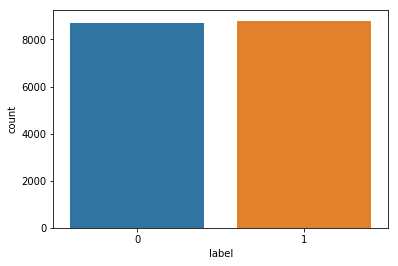

In [10]:
sns.countplot(train['label']);

O Grafico mostra que lidamos com um dataset perfeitamente balanceado. Isso é bom porque a análise será mais fácil de entender e interpretar a métrica de acurácia do modelo.

In [11]:
# Função para mostrar o wordcloud das palavras que mais aparecem nas reviews.

def plot_wordcloud(data, title):
    wordcloud = WordCloud(background_color='black',
                          stopwords=set(STOPWORDS),
                          max_words=200,
                          max_font_size=100,
                          random_state=17,
                          width=800,
                          height=400,
                          mask=None)
    wordcloud.generate(str(data))
    plt.figure(figsize=(15.0,10.0))
    plt.axis('off')
    plt.title(title)
    plt.imshow(wordcloud);

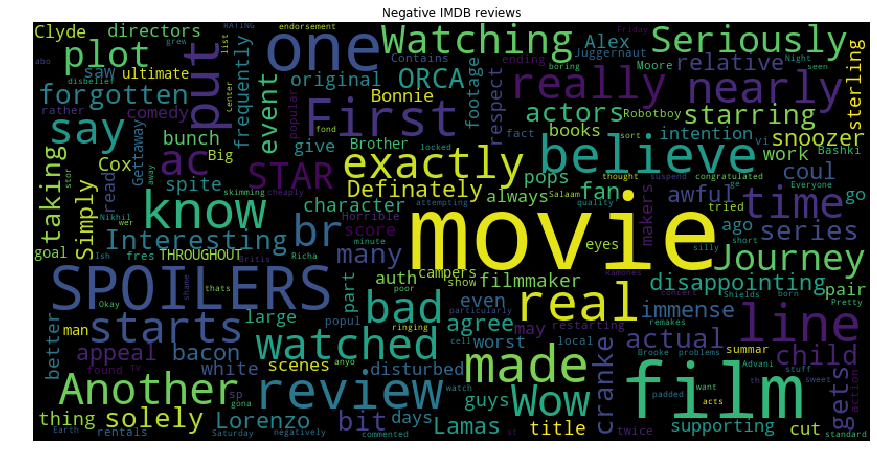

In [12]:
plot_wordcloud(train.loc[train['label']==0]['review'], 'Negative IMDB reviews')

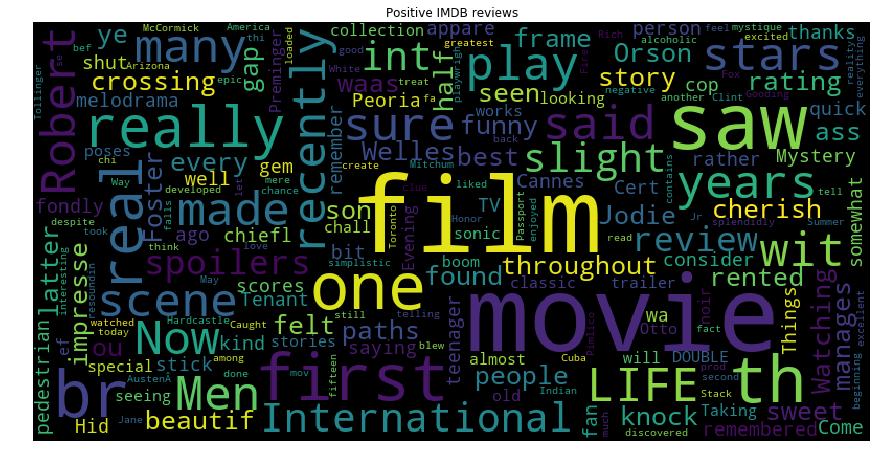

In [13]:
plot_wordcloud(train.loc[train['label']==1]['review'], 'Positive IMDB reviews')

Como podemos ver ambas as categorias as palavras que mais aparecem são "Movie" e "Film", e não é estranho, porque o dataset contem reviews de filmes. 

Negative reviews contém palavras como: "Really" (pode ser usado de forma sarcástica ou para ampliar a opinião da pessoa), "Bad", "Disappointing", "Awful" (nada bom sobre o filme).

Positive reviews contém palavras como: "Best", "Epic", "Good" (que geralmente são usados para expressar a satisfação de alguém).

# 3. Pré-Processamento

In [14]:
stopWords = stopwords.words('english')

* Função para limpar o dataset onde:
    * os carateres especiais são removidos
    * todas as letras são convertidas para lowercase 

In [15]:
def CleanData(sentence):
    processedList = ""
    
    #convert to lowercase and ignore special charcter
    sentence = re.sub(r'[^A-Za-z0-9\s.]', r'', str(sentence).lower())
    sentence = re.sub(r'\n', r' ', sentence)
    
    sentence = " ".join([word for word in sentence.split() if word not in stopWords])
    
    return sentence

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17500 entries, 13533 to 1749
Data columns (total 3 columns):
review    17500 non-null object
label     17500 non-null int64
file      17500 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [17]:
# Review sem o processamento

train['review'].iloc[0]

"Interesting film about an actual event that took place during the Civil War in Vermont. It kept my attention to the end and I don't regret viewing it. I haven't ever read any on this raid incident so I was curious to see if the rebels pulled it off. I enjoy historical films from that era.<br /><br />My major complaint is with the Confederate uniforms. They look too good!!! The acting was a little stiff at times. I like the old man eating the mashed potatoes because he didn't have any teeth. The wounded soldier playing fetch with a hound was a little strange. Overall, it was a descent film."

In [18]:
# Review Com o processamento

CleanData(train['review'].iloc[0])

'interesting film actual event took place civil war vermont. kept attention end dont regret viewing it. havent ever read raid incident curious see rebels pulled off. enjoy historical films era.br br major complaint confederate uniforms. look good acting little stiff times. like old man eating mashed potatoes didnt teeth. wounded soldier playing fetch hound little strange. overall descent film.'

In [19]:
train['processed_reviews'] = train['review'].map(lambda x: CleanData(x))
valid['processed_reviews'] = valid['review'].map(lambda x: CleanData(x))
test['processed_reviews'] = test['review'].map(lambda x: CleanData(x))

In [20]:
display(train.head())
display(valid.head())
display(test.head())

,review,label,file,processed_reviews
13533,Interesting film about an actual event that to...,0,6575_4.txt,interesting film actual event took place civil...
47978,I don't know why I'm taking the time to review...,0,3830_1.txt,dont know im taking time review wasteoftime mo...
19168,I felt this film - throughout. I waas impresse...,1,10806_9.txt,felt film throughout. waas impressed russell c...
27126,Watching this again after a gap of many years ...,1,6013_7.txt,watching gap many years remembering flop upon ...
27901,The rating is only a 5 because it's a movie th...,1,3945_10.txt,rating 5 movie could used better acting direct...


,review,label,file,processed_reviews
4,"Yes, Giorgio, is a feel good movie. A little r...",1,9750_10.txt,yes giorgio feel good movie. little romance gr...
20,Evening is an entertaining movie with quite so...,1,1784_10.txt,evening entertaining movie quite depth. actors...
24,"It seems to me, as a recent film school gradua...",0,6904_2.txt,seems recent film school graduate times new ze...
26,Wow. Rarely have I felt the need to comment on...,0,1228_2.txt,wow. rarely felt need comment movies lately on...
32,"The Finnish version of Robert Altman's ""Short ...",1,3238_9.txt,finnish version robert altmans short cuts set ...


,review,label,file,processed_reviews
0,This is unfortunately Carlin's last recorded H...,-1,4374_9.txt,unfortunately carlins last recorded hbo concer...
1,"The vampire ""craze"" has, in my opinion, actual...",-1,155_8.txt,vampire craze opinion actually proved worthine...
2,The story of an obsessed lover (Shahrukh Khan)...,-1,12055_8.txt,story obsessed lover shahrukh khan lengths goe...
3,"In my opinion, National Velvet is one of the t...",-1,6800_10.txt,opinion national velvet one top family classic...
4,Don Wilson stars as a cop who enjoys the occas...,-1,6986_2.txt,wilson stars cop enjoys occasional virtual rea...


## 3.1 Wordcloud das reviews negativas, antes e depois do processamento.

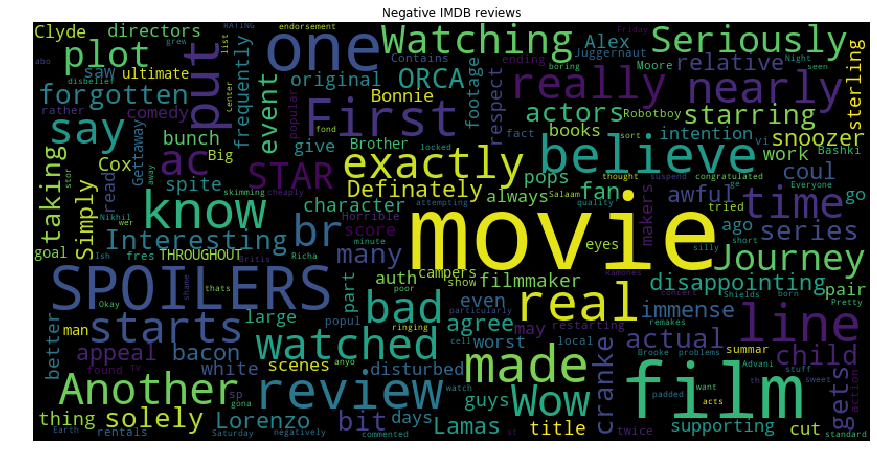

In [21]:
plot_wordcloud(train.loc[train['label']==0]['review'], 'Negative IMDB reviews')

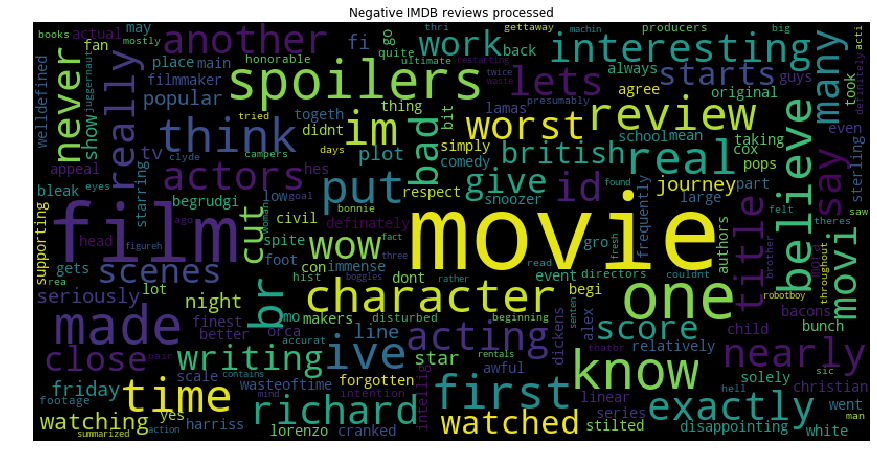

In [22]:
plot_wordcloud(train.loc[train['label']==0]['processed_reviews'], 'Negative IMDB reviews processed')

## 3.2 Wordcloud das reviews positivas, antes e depois do processamento.

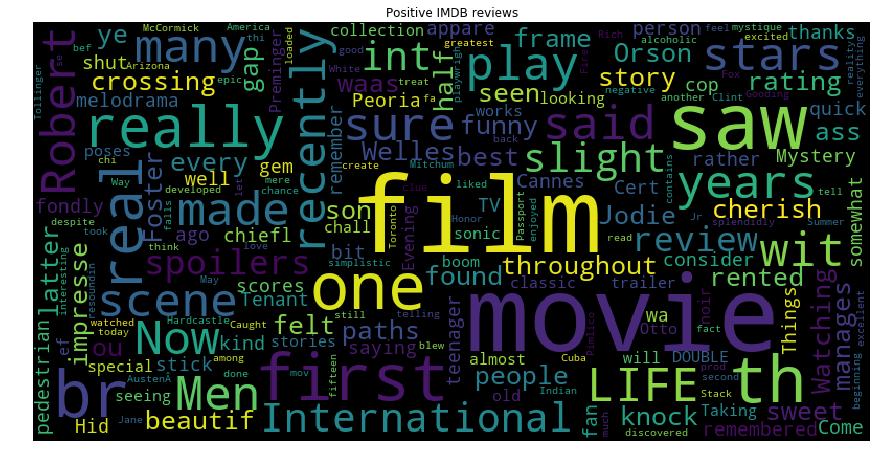

In [23]:
plot_wordcloud(train.loc[train['label']==1]['review'], 'Positive IMDB reviews')

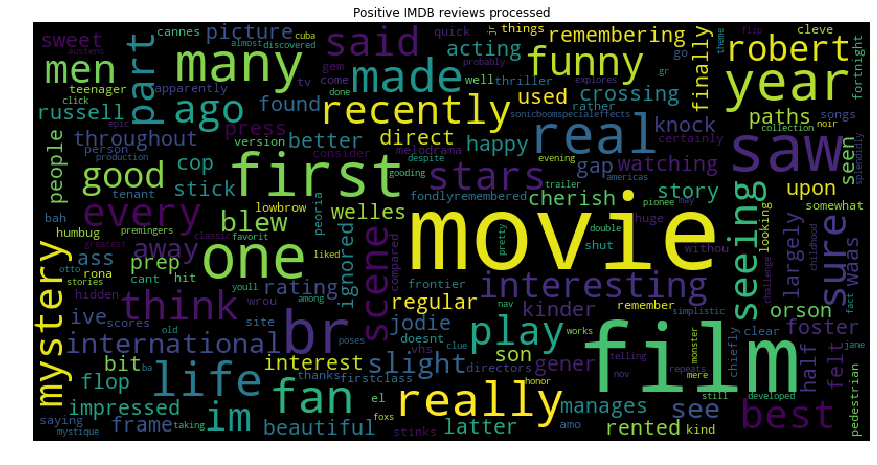

In [24]:
plot_wordcloud(train.loc[train['label']==1]['processed_reviews'], 'Positive IMDB reviews processed')

# 4. Treinamento

In [25]:
# Remoção das colunas que não serão utilizadas

clean_train = train.drop(['review', 'file'], axis=1).copy()
clean_valid = valid.drop(['review', 'file'], axis=1).copy()
clean_test = test.drop(['review', 'file', 'label'], axis=1).copy()

In [26]:
display(clean_train.head())
display(clean_valid.head())
display(clean_test.head())

,label,processed_reviews
13533,0,interesting film actual event took place civil...
47978,0,dont know im taking time review wasteoftime mo...
19168,1,felt film throughout. waas impressed russell c...
27126,1,watching gap many years remembering flop upon ...
27901,1,rating 5 movie could used better acting direct...


,label,processed_reviews
4,1,yes giorgio feel good movie. little romance gr...
20,1,evening entertaining movie quite depth. actors...
24,0,seems recent film school graduate times new ze...
26,0,wow. rarely felt need comment movies lately on...
32,1,finnish version robert altmans short cuts set ...


,processed_reviews
0,unfortunately carlins last recorded hbo concer...
1,vampire craze opinion actually proved worthine...
2,story obsessed lover shahrukh khan lengths goe...
3,opinion national velvet one top family classic...
4,wilson stars cop enjoys occasional virtual rea...


In [27]:
X_train = clean_train['processed_reviews']
y_train = clean_train['label']

X_valid = clean_valid['processed_reviews']
y_valid = clean_valid['label']

In [28]:
display(X_train.shape)
display(X_valid.shape)
display(y_train.shape)
display(y_valid.shape)

(17500,)

(7500,)

(17500,)

(7500,)

## 4.1. Pós-processamento do texto usando TF-IDF (Term frequency-inverse document frequency)

* Permite ponderar os termos com base em quão importantes eles são.
* O peso maior é dado a termos que aparecem frequentemente em um conjunto específico.
* O TfidfVectorizor usa o argumento, mindf, que permite especificar um número mínimo de ocorrencia nos quais um token precisa aparecer para se tornar parte do vocabulário.
* Isso ajuda a remover algumas palavras que podem aparecer poucas vezes e provavelmente não serão preditores úteis.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(["thats","weve","dont","lets","youre","im","thi","ha","wa",
                                            "st","ask","want","like","thank","know","susan","ryan",
                                            "say","got","ought","ive","theyre"])

tfidf = TfidfVectorizer(min_df=2, max_features=10000, stop_words=stop_words)

In [30]:
trainX = tfidf.fit_transform(X_train).toarray()
validX = tfidf.transform(X_valid).toarray()

## 4.2. Seleção de Feature


In [31]:
from scipy.stats.stats import pearsonr

getCorrelation = np.vectorize(lambda x: pearsonr(trainX[:,x], y_train)[0])
correlations = getCorrelation(np.arange(trainX.shape[1]))
print(correlations)

[-1.05268726e-02 -4.46449266e-02  1.25846414e-04 ... -9.21574437e-06
  1.52302460e-02  2.00725364e-02]


In [32]:
allIndeces = np.argsort(-correlations)
bestIndeces = allIndeces[np.concatenate([np.arange(1000), np.arange(-1000, 0)])]

In [33]:
vocabulary = np.array(tfidf.get_feature_names())
print(vocabulary[bestIndeces][:10])
print(vocabulary[bestIndeces][-10:])

['great' 'excellent' 'wonderful' 'best' 'love' 'perfect' 'amazing'
 'beautiful' 'favorite' 'loved']
['plot' 'horrible' 'poor' 'boring' 'terrible' 'worse' 'awful' 'waste'
 'worst' 'bad']


In [34]:
trainX = trainX[:,bestIndeces]
validX = validX[:,bestIndeces]

In [35]:
print(trainX.shape, y_train.shape)
print(validX.shape, y_valid.shape)

(17500, 2000) (17500,)
(7500, 2000) (7500,)


In [36]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras import optimizers

Using TensorFlow backend.


In [37]:
DROPOUT = 0.5
ACTIVATION = "tanh"

model = Sequential([    
    Dense(int(trainX.shape[1]/2), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(trainX.shape[1]/2), activation=ACTIVATION, input_dim=trainX.shape[1]),
    Dropout(DROPOUT),
    Dense(int(trainX.shape[1]/4), activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(100, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(20, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(5, activation=ACTIVATION),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid'),
])

In [38]:
model.compile(optimizer=optimizers.Adam(0.00005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               50100     
__________

## 4.3. Model Training

In [39]:
EPOCHS = 30
BATCHSIZE = 1500

In [40]:
model.fit(trainX, y_train, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(validX, y_valid))

Train on 17500 samples, validate on 7500 samples
Epoch 1/30
17500/17500 [==============================] - 7s 414us/step - loss: 0.7013 - acc: 0.5139 - val_loss: 0.6786 - val_acc: 0.6979
Epoch 2/30
17500/17500 [==============================] - 6s 344us/step - loss: 0.6881 - acc: 0.5419 - val_loss: 0.6625 - val_acc: 0.7693
Epoch 3/30
17500/17500 [==============================] - 6s 345us/step - loss: 0.6705 - acc: 0.5809 - val_loss: 0.6436 - val_acc: 0.8048
Epoch 4/30
17500/17500 [==============================] - 6s 346us/step - loss: 0.6554 - acc: 0.6053 - val_loss: 0.6193 - val_acc: 0.8201
Epoch 5/30
17500/17500 [==============================] - 6s 346us/step - loss: 0.6288 - acc: 0.6550 - val_loss: 0.5869 - val_acc: 0.8283
Epoch 6/30
17500/17500 [==============================] - 6s 354us/step - loss: 0.5972 - acc: 0.6961 - val_loss: 0.5467 - val_acc: 0.8371
Epoch 7/30
17500/17500 [==============================] - 6s 350us/step - loss: 0.5650 - acc: 0.7273 - val_loss: 0.5023 - v

In [41]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

x = np.arange(EPOCHS)
history = model.history.history

data = [
    go.Scatter(x=x, y=history["acc"], name="Train Accuracy", marker=dict(size=5), yaxis='y2'),
    go.Scatter(x=x, y=history['val_acc'], name="Valid Accuracy", marker=dict(size=5), yaxis='y2'),
    go.Scatter(x=x, y=history["loss"], name="Train Loss", marker=dict(size=5)),
    go.Scatter(x=x, y=history["val_loss"], name="Valid Loss", marker=dict(size=5))
]
layout = go.Layout(
    title="Model Training Evolution", font=dict(family='Palatino'), xaxis=dict(title='Epoch', dtick=1),
    yaxis1=dict(title="Loss", domain=[0, 0.45]), yaxis2=dict(title="Accuracy", domain=[0.55, 1]),
)
py.iplot(go.Figure(data=data, layout=layout), show_link=False)

## 4.4. Model Evaluation

In [42]:
clean_train["probability"] = model.predict(trainX)
clean_train["prediction"] = clean_train.probability-0.5>0
clean_train["truth"] = clean_train.label==1
clean_train.tail()

,label,processed_reviews,probability,prediction,truth
19311,0,ive seen movie thats sort like transsexual dru...,0.093505,False,False
43503,0,thought id locked away padded cell theyd throw...,0.171796,False,False
42910,0,line starts one silly boring british sci fi fi...,0.094432,False,False
15194,0,bogus journey never comes close matching wit c...,0.089262,False,False
1749,0,another long line flicks made people think kno...,0.085325,False,False


In [43]:
# train.head()

In [44]:
print(model.evaluate(trainX, y_train))
print((clean_train.truth==clean_train.prediction).mean())

17500/17500 [==============================] - 4s 253us/step
[0.23436953643049513, 0.9285714285305569]
0.9285714285714286


## Error Analysis

In [45]:
trainCross = clean_train.groupby(["prediction", "truth"]).size().unstack()
trainCross

truth,False,True
prediction,,
False,8042,586
True,664,8208


In [46]:
unseen = pd.Series("this movie very good")

In [47]:
unseen = tfidf.transform(unseen).toarray()  # Feature engineering
unseen = unseen[:,bestIndeces]              # Feature selection
probability = model.predict(unseen)[0,0]  # Network feedforward

In [48]:
print(probability)
print("Positive!") if probability > 0.5 else print("Negative!")

0.72919446
Positive!
